In this notebook I run a variety of models to predict garment worker productivity, and find that Random Forest performs best. Through feature selection I discover that when incentives are offered, incentive size correlates with productivity while RMSE decreases from 0.1226 for all instances to 0.0840 for this subset of the dataset. In addition, the model can be simplified substantially, as dropping 16 of 24 features results in an RMSE of 0.0832. These results suggest that expanding the use of incentives may be a strategy worth exploring. For tasks with zero incentive, adding an average incentive increases their mean daily productivity by 13.34%.  I also discovered that productivity may be increased 18% by for the longest tasks if they are divided into shorter ones.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from sklearn import model_selection
from sklearn.preprocessing import StandardScaler, scale
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, RepeatedKFold
from sklearn.linear_model import LinearRegression, ElasticNet, ElasticNetCV
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

Preprocess data. Begin by checking for null values.

In [2]:
garment_prod = pd.read_csv("data/garments_worker_productivity.csv")
garment_prod.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   date                   1197 non-null   object 
 1   quarter                1197 non-null   object 
 2   department             1197 non-null   object 
 3   day                    1197 non-null   object 
 4   team                   1197 non-null   int64  
 5   targeted_productivity  1197 non-null   float64
 6   smv                    1197 non-null   float64
 7   wip                    691 non-null    float64
 8   over_time              1197 non-null   int64  
 9   incentive              1197 non-null   int64  
 10  idle_time              1197 non-null   float64
 11  idle_men               1197 non-null   int64  
 12  no_of_style_change     1197 non-null   int64  
 13  no_of_workers          1197 non-null   float64
 14  actual_productivity    1197 non-null   float64
dtypes: f

In [3]:
garment_prod['wip'].describe()

count      691.000000
mean      1190.465991
std       1837.455001
min          7.000000
25%        774.500000
50%       1039.000000
75%       1252.500000
max      23122.000000
Name: wip, dtype: float64

The 'wip' column shows number of works in progress. Given the large number of nulls and that min = 7, assume nulls should be considered 0.

In [4]:
garment_prod['wip'] = garment_prod['wip'].fillna(0)

Convert 'date' to datetime to facilitate anlysis.

In [5]:
garment_prod['date'] = pd.to_datetime(garment_prod['date'])

In [6]:
garment_prod.describe()

,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity
count,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000,1197.000000
mean,6.426901,0.729632,15.062172,687.228070,4567.460317,38.210526,0.730159,0.369256,0.150376,34.609858,0.735091
std,3.463963,0.097891,10.943219,1514.582341,3348.823563,160.182643,12.709757,3.268987,0.427848,22.197687,0.174488
min,1.000000,0.070000,2.900000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.233705
25%,3.000000,0.700000,3.940000,0.000000,1440.000000,0.000000,0.000000,0.000000,0.000000,9.000000,0.650307
50%,6.000000,0.750000,15.260000,586.000000,3960.000000,0.000000,0.000000,0.000000,0.000000,34.000000,0.773333
75%,9.000000,0.800000,24.260000,1083.000000,6960.000000,50.000000,0.000000,0.000000,0.000000,57.000000,0.850253
max,12.000000,0.800000,54.560000,23122.000000,25920.000000,3600.000000,300.000000,45.000000,2.000000,89.000000,1.120437


For first pass visual exploration of data, plot each predictor vs. the target (actual_productivity).

In [7]:
predictors = list(garment_prod.columns)
predictors.remove('actual_productivity')

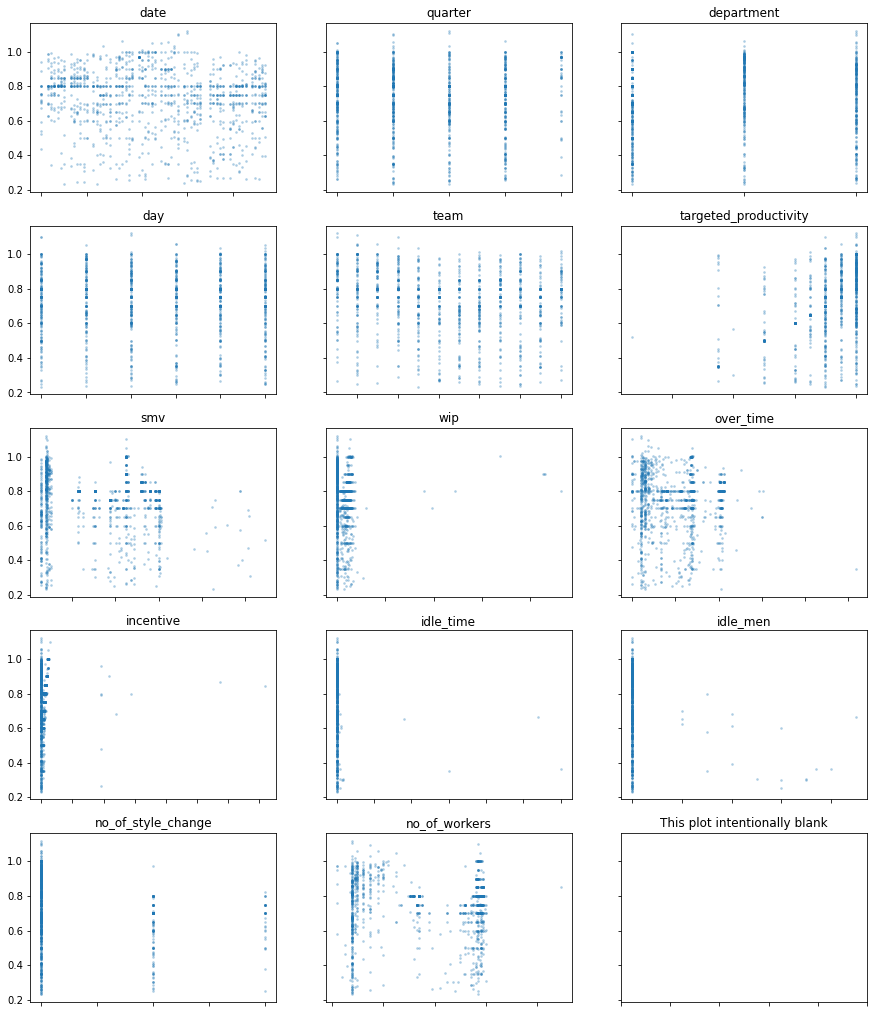

In [8]:
fig, ax = plt.subplots(5, 3, figsize=(15, 18), sharey='row')
# Use loop to generate first 3 rows of plots
for i in range(0, 4):
    for j in range(0, 3):
        index = 3*i+j
        predictor = predictors[index]
        x=garment_prod.iloc[:, index]
        y=garment_prod.loc[:, 'actual_productivity']
        ax[i, j].scatter(x, y, s = 3, alpha = 0.25)
        ax[i, j].set_title(predictor)
        ax[i, j].tick_params(labelbottom=False)
# Generate remaining plots
ax[4, 0].scatter(garment_prod['no_of_style_change'], garment_prod['actual_productivity'], s = 3, alpha = 0.25)
ax[4, 0].set_title('no_of_style_change')
ax[4, 0].tick_params(labelbottom=False)
ax[4, 1].scatter(garment_prod['no_of_workers'], garment_prod['actual_productivity'], s = 3, alpha = 0.25)
ax[4, 1].set_title('no_of_workers')
ax[4, 1].tick_params(labelbottom=False)
ax[4, 2].set_title('This plot intentionally blank')
ax[4, 2].tick_params(labelbottom=False)

Targeted productivity might correlate weakly with actual_productivity. Several of the predictors have outliers, which could be worth exploring at some point. First I will run some different models to see what they show.

Group predictor columns according to data type into three dataframes for preprocessing: nominal categorical, ordinal categorical, & numerical. 

In [9]:
# Select nominal categorical columns for encoding.
garment_nominal = garment_prod[['department', 'team']]
garment_nominal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   department  1197 non-null   object
 1   team        1197 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 18.8+ KB


In [10]:
# Select ordinal categorical columns for encoding.
garment_ordinal = garment_prod[['date', 'quarter', 'day']]
garment_ordinal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   date     1197 non-null   datetime64[ns]
 1   quarter  1197 non-null   object        
 2   day      1197 non-null   object        
dtypes: datetime64[ns](1), object(2)
memory usage: 28.2+ KB


In [11]:
# Select numerical columns.
garment_numerical = garment_prod.iloc[:, 5:]
garment_numerical.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   targeted_productivity  1197 non-null   float64
 1   smv                    1197 non-null   float64
 2   wip                    1197 non-null   float64
 3   over_time              1197 non-null   int64  
 4   incentive              1197 non-null   int64  
 5   idle_time              1197 non-null   float64
 6   idle_men               1197 non-null   int64  
 7   no_of_style_change     1197 non-null   int64  
 8   no_of_workers          1197 non-null   float64
 9   actual_productivity    1197 non-null   float64
dtypes: float64(6), int64(4)
memory usage: 93.6 KB


Encode nominal features, 'department' and 'team', using One Hot. First, check number of categories in each of these columns.

In [12]:
garment_nominal.iloc[:, 0].unique()

array(['sweing', 'finishing ', 'finishing'], dtype=object)

Some 'department' entries include a space at the end. Remove those spaces and correct mispelling of 'sewing'.

In [13]:
garment_nominal.iloc[:, 0].replace({'sweing': 'sewing', 'finishing ': 'finishing'}, inplace=True)
garment_nominal.iloc[:, 0].unique()

array(['sewing', 'finishing'], dtype=object)

In [14]:
team_categories = garment_nominal['team'].unique()
team_categories.sort(axis=0)
team_categories

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12], dtype=int64)

Utilize get_dummies to encode nominal columns using OHE. Function drops orgininal columns.

In [15]:
garment_nom_encoded = pd.get_dummies(garment_nominal, columns = ['department', 'team'])
garment_nom_encoded.head()

,department_finishing,department_sewing,team_1,team_2,team_3,team_4,team_5,team_6,team_7,team_8,team_9,team_10,team_11,team_12
0,0,1,0,0,0,0,0,0,0,1,0,0,0,0
1,1,0,1,0,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,0,0,1,0
3,0,1,0,0,0,0,0,0,0,0,0,0,0,1
4,0,1,0,0,0,0,0,1,0,0,0,0,0,0


In [16]:
# Double check that all data were encoded.
garment_nom_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype
---  ------                --------------  -----
 0   department_finishing  1197 non-null   uint8
 1   department_sewing     1197 non-null   uint8
 2   team_1                1197 non-null   uint8
 3   team_2                1197 non-null   uint8
 4   team_3                1197 non-null   uint8
 5   team_4                1197 non-null   uint8
 6   team_5                1197 non-null   uint8
 7   team_6                1197 non-null   uint8
 8   team_7                1197 non-null   uint8
 9   team_8                1197 non-null   uint8
 10  team_9                1197 non-null   uint8
 11  team_10               1197 non-null   uint8
 12  team_11               1197 non-null   uint8
 13  team_12               1197 non-null   uint8
dtypes: uint8(14)
memory usage: 16.5 KB


Encode 'quarter' and 'day' with ordinal method, using sequence of integers as values in dictionaries to map data in the "quarter" and "day" columns to integers in new columns.

In [17]:
# turn off chained assignments warning (false positive) because mapping to new columns is working.
pd.set_option('chained_assignment', None)
Quarter_dict = {'Quarter1': 1, 'Quarter2': 2, 'Quarter3': 3, 'Quarter4': 4, 'Quarter5': 5}
garment_ordinal['quarter_ordinal'] = garment_ordinal.loc[:, 'quarter'].map(Quarter_dict)


Day_dict = {'Monday': 1, 'Tuesday': 2, 'Wednesday': 3, 'Thursday': 4, 'Friday': 5, 'Saturday': 6, 'Sunday': 7}
garment_ordinal['day_ordinal'] = garment_ordinal.loc[:, 'day'].map(Day_dict)
garment_ordinal.head()

,date,quarter,day,quarter_ordinal,day_ordinal
0,2015-01-01,Quarter1,Thursday,1,4
1,2015-01-01,Quarter1,Thursday,1,4
2,2015-01-01,Quarter1,Thursday,1,4
3,2015-01-01,Quarter1,Thursday,1,4
4,2015-01-01,Quarter1,Thursday,1,4


In [18]:
garment_ordinal.drop(labels=['quarter', 'day'], axis=1, inplace=True)
garment_ordinal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   date             1197 non-null   datetime64[ns]
 1   quarter_ordinal  1197 non-null   int64         
 2   day_ordinal      1197 non-null   int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 28.2 KB


To use datetime in regression, perform ordinal encoding by mapping with python's datetime.toordinal method.

In [19]:
from datetime import datetime 
garment_ordinal['date'] = garment_ordinal['date'].map(datetime.toordinal)

In [20]:
garment_ordinal['date'].describe()

count      1197.000000
mean     735633.456140
std          20.630062
min      735599.000000
25%      735616.000000
50%      735632.000000
75%      735652.000000
max      735668.000000
Name: date, dtype: float64

Concatenate encoded nominal and ordinal columns.

In [21]:
garment_categorical = pd.concat([garment_nom_encoded, garment_ordinal], axis=1)
garment_categorical.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype
---  ------                --------------  -----
 0   department_finishing  1197 non-null   uint8
 1   department_sewing     1197 non-null   uint8
 2   team_1                1197 non-null   uint8
 3   team_2                1197 non-null   uint8
 4   team_3                1197 non-null   uint8
 5   team_4                1197 non-null   uint8
 6   team_5                1197 non-null   uint8
 7   team_6                1197 non-null   uint8
 8   team_7                1197 non-null   uint8
 9   team_8                1197 non-null   uint8
 10  team_9                1197 non-null   uint8
 11  team_10               1197 non-null   uint8
 12  team_11               1197 non-null   uint8
 13  team_12               1197 non-null   uint8
 14  date                  1197 non-null   int64
 15  quarter_ordinal       1197 non-null   int64
 16  day_or

Drop last department & team columns to reduce impacts on regression models by the multicollinearity introduced by OHE encoding. The information in the deleted columns is still available to the model, though, because if the value of the deleted column was 1, the row will now have 0's for all remaining columns encoding that feature.

In [22]:
garment_categorical.drop(labels = ['department_sewing', 'team_12'], axis = 1, inplace = True)
garment_categorical.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype
---  ------                --------------  -----
 0   department_finishing  1197 non-null   uint8
 1   team_1                1197 non-null   uint8
 2   team_2                1197 non-null   uint8
 3   team_3                1197 non-null   uint8
 4   team_4                1197 non-null   uint8
 5   team_5                1197 non-null   uint8
 6   team_6                1197 non-null   uint8
 7   team_7                1197 non-null   uint8
 8   team_8                1197 non-null   uint8
 9   team_9                1197 non-null   uint8
 10  team_10               1197 non-null   uint8
 11  team_11               1197 non-null   uint8
 12  date                  1197 non-null   int64
 13  quarter_ordinal       1197 non-null   int64
 14  day_ordinal           1197 non-null   int64
dtypes: int64(3), uint8(12)
memory usage: 42.2 KB


Select predictor and target columns and split into train and test subsets, then scale (fit & transform) X_train and transform X_test using fit parameters from X_train.

In [23]:
# Concatenate categorical & numerical columns & save complete data set.
garment_prepped = pd.concat([garment_categorical, garment_numerical], axis=1)
# Drop target 'actual_productivity' from predictors.
X = garment_prepped.drop(columns = 'actual_productivity')
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   department_finishing   1197 non-null   uint8  
 1   team_1                 1197 non-null   uint8  
 2   team_2                 1197 non-null   uint8  
 3   team_3                 1197 non-null   uint8  
 4   team_4                 1197 non-null   uint8  
 5   team_5                 1197 non-null   uint8  
 6   team_6                 1197 non-null   uint8  
 7   team_7                 1197 non-null   uint8  
 8   team_8                 1197 non-null   uint8  
 9   team_9                 1197 non-null   uint8  
 10  team_10                1197 non-null   uint8  
 11  team_11                1197 non-null   uint8  
 12  date                   1197 non-null   int64  
 13  quarter_ordinal        1197 non-null   int64  
 14  day_ordinal            1197 non-null   int64  
 15  targ

In [24]:
y = garment_prod['actual_productivity']

In [25]:
# Split into train & test subsets before scaling.
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.3, random_state=0) 
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 837 entries, 922 to 684
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   department_finishing   837 non-null    uint8  
 1   team_1                 837 non-null    uint8  
 2   team_2                 837 non-null    uint8  
 3   team_3                 837 non-null    uint8  
 4   team_4                 837 non-null    uint8  
 5   team_5                 837 non-null    uint8  
 6   team_6                 837 non-null    uint8  
 7   team_7                 837 non-null    uint8  
 8   team_8                 837 non-null    uint8  
 9   team_9                 837 non-null    uint8  
 10  team_10                837 non-null    uint8  
 11  team_11                837 non-null    uint8  
 12  date                   837 non-null    int64  
 13  quarter_ordinal        837 non-null    int64  
 14  day_ordinal            837 non-null    int64  
 15  targ

Continue preprocessing data for model comparison.

In [26]:
# Select predictors for scaling, including numerical and encoded ordinal columns.
X_train_scalable = X_train.drop(X.iloc[:, 0:12], axis = 1)
X_test_scalable = X_test.drop(X.iloc[:, 0:12], axis = 1)
# X_train_scalable.info()
X_test_scalable.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 360 entries, 700 to 1048
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   date                   360 non-null    int64  
 1   quarter_ordinal        360 non-null    int64  
 2   day_ordinal            360 non-null    int64  
 3   targeted_productivity  360 non-null    float64
 4   smv                    360 non-null    float64
 5   wip                    360 non-null    float64
 6   over_time              360 non-null    int64  
 7   incentive              360 non-null    int64  
 8   idle_time              360 non-null    float64
 9   idle_men               360 non-null    int64  
 10  no_of_style_change     360 non-null    int64  
 11  no_of_workers          360 non-null    float64
dtypes: float64(5), int64(7)
memory usage: 36.6 KB


In [27]:
# Scale ordinal & numerical columns in X_train,convert ndarray output to dataframe as float dtype, & name columns.
scaler = StandardScaler()
X_train_scaling = scaler.fit_transform(X_train_scalable)
X_train_scaled = pd.DataFrame(X_train_scaling)
X_train_scaled = X_train_scaled.astype('float')
X_train_scaled.columns = ['date', 'quarter_ordinal','day_ordinal', 'targeted_productivity', 'smv', 'wip', 'over_time', 'incentive', 'idle_time', 'idle_men', 'no_of_style_change', 'no_of_workers']
X_train_scaled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 837 entries, 0 to 836
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   date                   837 non-null    float64
 1   quarter_ordinal        837 non-null    float64
 2   day_ordinal            837 non-null    float64
 3   targeted_productivity  837 non-null    float64
 4   smv                    837 non-null    float64
 5   wip                    837 non-null    float64
 6   over_time              837 non-null    float64
 7   incentive              837 non-null    float64
 8   idle_time              837 non-null    float64
 9   idle_men               837 non-null    float64
 10  no_of_style_change     837 non-null    float64
 11  no_of_workers          837 non-null    float64
dtypes: float64(12)
memory usage: 78.6 KB


In [28]:
# Use fit paramaters from X_train to transform X_test, then convert back to df.
X_test_scaling = scaler.transform(X_test_scalable)
X_test_scaled = pd.DataFrame(X_test_scaling)
X_test_scaled = X_test_scaled.astype('float')
X_test_scaled.columns = ['date', 'quarter_ordinal','day_ordinal', 'targeted_productivity', 'smv', 'wip', 'over_time', 'incentive', 'idle_time', 'idle_men', 'no_of_style_change', 'no_of_workers']
X_test_scaled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 360 entries, 0 to 359
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   date                   360 non-null    float64
 1   quarter_ordinal        360 non-null    float64
 2   day_ordinal            360 non-null    float64
 3   targeted_productivity  360 non-null    float64
 4   smv                    360 non-null    float64
 5   wip                    360 non-null    float64
 6   over_time              360 non-null    float64
 7   incentive              360 non-null    float64
 8   idle_time              360 non-null    float64
 9   idle_men               360 non-null    float64
 10  no_of_style_change     360 non-null    float64
 11  no_of_workers          360 non-null    float64
dtypes: float64(12)
memory usage: 33.9 KB


Select binary columns (encoded nominal features) in X_train and X_test, then concatenate with scaled columns to make complete train and test dataframes. 

In [29]:
X_train_binary = X_train.iloc[:, 0:12]
X_test_binary = X_test.iloc[:, 0:12]
# X_test_binary.info()
X_train_binary.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 837 entries, 922 to 684
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype
---  ------                --------------  -----
 0   department_finishing  837 non-null    uint8
 1   team_1                837 non-null    uint8
 2   team_2                837 non-null    uint8
 3   team_3                837 non-null    uint8
 4   team_4                837 non-null    uint8
 5   team_5                837 non-null    uint8
 6   team_6                837 non-null    uint8
 7   team_7                837 non-null    uint8
 8   team_8                837 non-null    uint8
 9   team_9                837 non-null    uint8
 10  team_10               837 non-null    uint8
 11  team_11               837 non-null    uint8
dtypes: uint8(12)
memory usage: 16.3 KB


In [30]:
# Reset index on binary dataframes to match indexing on scaled dataframes, whose indexing was reset during scaling process.
X_train_binary.reset_index(drop = True, inplace = True)
X_test_binary.reset_index(drop = True, inplace = True)

In [31]:
X_train = pd.concat([X_train_binary, X_train_scaled], axis=1)
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 837 entries, 0 to 836
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   department_finishing   837 non-null    uint8  
 1   team_1                 837 non-null    uint8  
 2   team_2                 837 non-null    uint8  
 3   team_3                 837 non-null    uint8  
 4   team_4                 837 non-null    uint8  
 5   team_5                 837 non-null    uint8  
 6   team_6                 837 non-null    uint8  
 7   team_7                 837 non-null    uint8  
 8   team_8                 837 non-null    uint8  
 9   team_9                 837 non-null    uint8  
 10  team_10                837 non-null    uint8  
 11  team_11                837 non-null    uint8  
 12  date                   837 non-null    float64
 13  quarter_ordinal        837 non-null    float64
 14  day_ordinal            837 non-null    float64
 15  target

In [32]:
X_test = pd.concat([X_test_binary, X_test_scaled], axis=1)
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 360 entries, 0 to 359
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   department_finishing   360 non-null    uint8  
 1   team_1                 360 non-null    uint8  
 2   team_2                 360 non-null    uint8  
 3   team_3                 360 non-null    uint8  
 4   team_4                 360 non-null    uint8  
 5   team_5                 360 non-null    uint8  
 6   team_6                 360 non-null    uint8  
 7   team_7                 360 non-null    uint8  
 8   team_8                 360 non-null    uint8  
 9   team_9                 360 non-null    uint8  
 10  team_10                360 non-null    uint8  
 11  team_11                360 non-null    uint8  
 12  date                   360 non-null    float64
 13  quarter_ordinal        360 non-null    float64
 14  day_ordinal            360 non-null    float64
 15  target

Try different methods to predict garment worker productivity. Start with linear regression.

In [33]:
linear_regression = LinearRegression()
linear_regression.fit(X_train, y_train)
# predict y to evaluate model
y_predicted_lr = linear_regression.predict(X_test)
#calculate RMSE and format as float to 4 decimal places
lr_error = 'RMSE = {:.4f}'.format(mean_squared_error(y_test, y_predicted_lr, squared = False))

To evaluate models, define function to calculate RMSE and plot predicted vs. actual productivity.

In [34]:
def evaluate(predicted, actual, RMSE):
    plt.scatter(predicted, actual, alpha = 0.5)
    plt.xlim(0.2, 1.2)
    plt.ylim(0.2, 1.2)
    plt.xlabel('Predicted Productivity')
    plt.ylabel('actual_productivity')
    plt.title('Precited vs. Actual Productivity')
    no_error_x = (0.2, 1.2)
    no_error_y = (0.2, 1.2)
    plt.plot(no_error_x, no_error_y)
    plt.figtext(0.15, 0.83, RMSE)

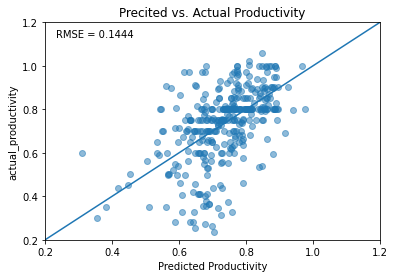

In [35]:
evaluate(predicted = y_predicted_lr, actual = y_test, RMSE = lr_error)

See if performance can be improved by reducing number of predictor dimensions with principal component analysis. Try principal component regression (PCR) with k-fold cross validation to optimize number of principal components.

In [36]:
#Shuffle df for cross-validation so all folds are similar (train_test_split shuffles by default, but that follows cv).
garment_shuf = shuffle(garment_prepped, random_state=7)
garment_shuf.head()

,department_finishing,team_1,team_2,team_3,team_4,team_5,team_6,team_7,team_8,team_9,...,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity
657,0,0,0,0,0,0,0,0,0,0,...,0.8,22.52,1388.0,6720,88,0.0,0,0,56.0,0.900800
98,0,0,0,0,0,0,1,0,0,0,...,0.8,11.61,910.0,4470,38,0.0,0,0,31.5,0.800077
63,1,0,0,0,1,0,0,0,0,0,...,0.8,3.94,0.0,3840,0,0.0,0,0,16.0,0.893663
905,0,0,0,0,0,0,0,0,0,0,...,0.8,15.26,1062.0,4080,50,0.0,0,0,34.0,0.800402
782,0,0,1,0,0,0,0,0,0,0,...,0.8,22.52,12.0,6900,0,0.0,0,0,57.5,0.432123


In [37]:
y_pca = garment_shuf['actual_productivity']
# X_pca = garment_shuf[['smv', 'wip', 'over_time', 'incentive', 'no_of_style_change', 'no_of_workers']]
# columns to drop , 'targeted_productivity','idle_time',
X_pca = garment_shuf.drop(columns = ['actual_productivity'])
X_pca.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1197 entries, 657 to 175
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   department_finishing   1197 non-null   uint8  
 1   team_1                 1197 non-null   uint8  
 2   team_2                 1197 non-null   uint8  
 3   team_3                 1197 non-null   uint8  
 4   team_4                 1197 non-null   uint8  
 5   team_5                 1197 non-null   uint8  
 6   team_6                 1197 non-null   uint8  
 7   team_7                 1197 non-null   uint8  
 8   team_8                 1197 non-null   uint8  
 9   team_9                 1197 non-null   uint8  
 10  team_10                1197 non-null   uint8  
 11  team_11                1197 non-null   uint8  
 12  date                   1197 non-null   int64  
 13  quarter_ordinal        1197 non-null   int64  
 14  day_ordinal            1197 non-null   int64  
 15  tar

In [38]:
# Scale the predictor variables and perform PCA on them.
pca = PCA()
X_reduced = pca.fit_transform(scale(X_pca))
X_reduced.shape

(1197, 24)

In [39]:
# Use k-fold cross-validation to evaluate model performance using k = 10 folds, repeated 3 times.
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

regr = LinearRegression()
mse = []
mse

[]

In [40]:
# Calculate the average of MSE from each split without using any of the principal components.
score = -1*model_selection.cross_val_score(regr,
           np.ones((len(X_reduced),1)), y_pca, cv=cv,
           scoring='neg_mean_squared_error').mean()    
mse.append(score)
mse

[0.0304612646170554]

In [41]:
# Calculate MSE using cross-validation, adding one component at a time until all components are used.
for i in np.arange(1, 25):
    score = -1*model_selection.cross_val_score(regr,
               X_reduced[:,:i], y_pca, cv=cv, scoring='neg_mean_squared_error').mean()
    mse.append(score)

Text(0.5, 1.0, 'MSE vs. # of Principal Components')

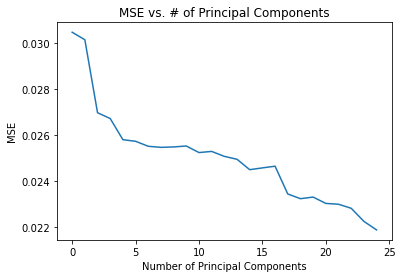

In [42]:
# Plot cross-validation results    
plt.plot(mse)
plt.xlabel('Number of Principal Components')
plt.ylabel('MSE')
plt.title('MSE vs. # of Principal Components')

In [43]:
np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)

array([ 15.63,  22.74,  29.  ,  34.39,  39.28,  43.93,  48.54,  53.12,
        57.7 ,  62.27,  66.84,  71.36,  75.79,  80.2 ,  83.97,  87.62,
        90.8 ,  93.91,  96.16,  97.87,  99.05,  99.55,  99.89, 100.  ])

MSE decreases with each additional component up to 7 (the first MSE reflects no principle components), so can try 7 principal components in regression. However, the first 7 principal components only explay 53% of the variance. So can also try 14 principal components, which explain about 84% of the variance.

In [44]:
# Split into train & test subsets
X_pca_train,X_pca_test,y_pca_train,y_pca_test = train_test_split(X_pca, y_pca, test_size=0.3, random_state=0) 
# run PCA on train subset, scaling each predictor by fitting & transforming.
X_reduced_train = pca.fit_transform(scale(X_pca_train))

In [45]:
# Try regression using first 7 principal components.
regr7 = LinearRegression()
# run PCA on test subset, transforming (with fit from X_pca_train) & selecting first 7 principal components.
X_reduced_test7 = pca.transform(scale(X_pca_test))[:,:7]
# train model on first 7 principal components
regr7.fit(X_reduced_train[:,:7], y_pca_train)
# predict y to evaluate model
y_predicted_regr7 = regr7.predict(X_reduced_test7)
# calculate R2 by using trained model to predict target values and compare to actual values.
pc7_error = 'RMSE = {:.4f}'.format(mean_squared_error(y_pca_test, y_predicted_regr7, squared = False))

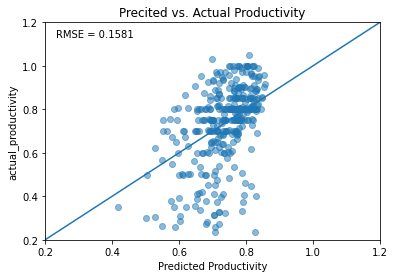

In [46]:
evaluate(predicted = y_predicted_regr7, actual = y_pca_test, RMSE = pc7_error)

In [47]:
# Try regression with 14 principal components.
regr14 = LinearRegression()
# run PCA on test subset, transforming (with fit from X_pca_train) & selecting first 14 principal components.
X_reduced_test14 = pca.transform(scale(X_pca_test))[:,:14]
# train model on first 14 principal components
regr14.fit(X_reduced_train[:,:14], y_pca_train)
# predict y to evaluate model
y_predicted_regr14 = regr14.predict(X_reduced_test14)
# calculate RMSE
pc14_error = 'RMSE = {:.4f}'.format(mean_squared_error(y_pca_test, y_predicted_regr14, squared = False))

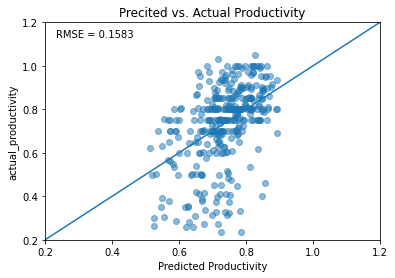

In [48]:
evaluate(predicted = y_predicted_regr14, actual = y_pca_test, RMSE = pc14_error)

The PCA did not improve model performance, so next try ridge & lasso together. ElasticNet does this. 

In [49]:
e_netCV = ElasticNetCV(cv = 10)
e_netCV.fit(X_train, y_train)
# predict y to evaluate model
y_predicted_e_netCV = e_netCV.predict(X_test)
# calculate RMSE
e_netCV_error = 'RMSE = {:.4f}'.format(mean_squared_error(y_predicted_e_netCV, y_test, squared = False))

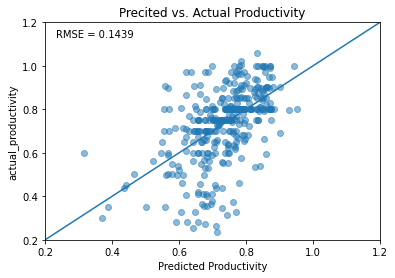

In [50]:
evaluate(predicted = y_predicted_e_netCV, actual = y_test, RMSE = e_netCV_error)

This is the lowest error of all models so far, lower than linear regression RMSE by 0.0142. What alpha and lambda values were best?

In [51]:
e_netCV.l1_ratio_

0.5

Cross-validation didn't change the balance between ridge and lasso.

In [52]:
e_netCV.alpha_

0.0013162279856429068

In [53]:
RFregr = RandomForestRegressor(random_state=0)
RFregr.fit(X_train, y_train)

RandomForestRegressor(random_state=0)

In [54]:
# predict y to evaluate model 
y_predicted_RFregr = RFregr.predict(X_test)
# calculate RMSE
RFregr_error = 'RMSE = {:.4f}'.format(mean_squared_error(y_predicted_RFregr, y_test, squared = False))

The sklearn 'alpha' value near 0 indicates that only a small amount of regularization was performed, and this seems to have improved performance slightly over non-regularized linear regression.

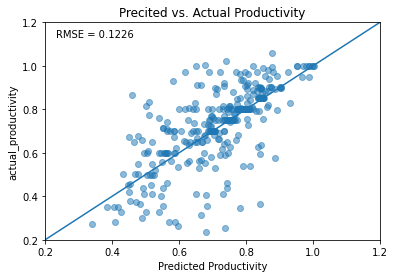

In [55]:
evaluate(predicted = y_predicted_RFregr, actual = y_test, RMSE = RFregr_error)

Try a neural network to see if it predicts productivity better.

In [56]:
import tensorflow.python.keras.backend
from tensorflow.python.keras import initializers, optimizers, regularizers,layers
# from tensorflow.python.keras.optimizers import SGD
from tensorflow.python.keras.constraints import maxnorm
from tensorflow.python.keras.models import Sequential, load_model
from tensorflow.python.keras.layers import Dense, Activation, Dropout, Flatten
from tensorflow.python.keras.utils import np_utils
from tensorflow.python.keras.wrappers.scikit_learn import KerasRegressor, KerasClassifier

In [57]:
model = Sequential()

In [58]:
#InputLayer
model.add(Dense(12, input_dim = 24, activation='relu'))

In [59]:
#Hidden Layers
model.add(Dense(5, activation='relu'))

In [60]:
#Output Layer
model.add(Dense(1, activation='relu'))

In [61]:
model.compile(loss=['mse'], optimizer='adam', metrics=['mse'])

In [62]:
history = model.fit(X_train, y_train, batch_size=35, epochs=20, validation_data=(X_test, y_test),verbose=1)

Epoch 1/20
24/24 [==============================] - 1s 11ms/step - loss: 0.5039 - mse: 0.5039 - val_loss: 0.4442 - val_mse: 0.4442
Epoch 2/20
24/24 [==============================] - 0s 2ms/step - loss: 0.3685 - mse: 0.3685 - val_loss: 0.2901 - val_mse: 0.2901
Epoch 3/20
24/24 [==============================] - 0s 2ms/step - loss: 0.2127 - mse: 0.2127 - val_loss: 0.1690 - val_mse: 0.1690
Epoch 4/20
24/24 [==============================] - 0s 3ms/step - loss: 0.1200 - mse: 0.1200 - val_loss: 0.1154 - val_mse: 0.1154
Epoch 5/20
24/24 [==============================] - 0s 2ms/step - loss: 0.0873 - mse: 0.0873 - val_loss: 0.0942 - val_mse: 0.0942
Epoch 6/20
24/24 [==============================] - 0s 3ms/step - loss: 0.0723 - mse: 0.0723 - val_loss: 0.0804 - val_mse: 0.0804
Epoch 7/20
24/24 [==============================] - 0s 2ms/step - loss: 0.0632 - mse: 0.0632 - val_loss: 0.0701 - val_mse: 0.0701
Epoch 8/20
24/24 [==============================] - 0s 2ms/step - loss: 0.0561 - mse: 0.0

In [63]:
# predict y to evaluate model
y_predicted_NN = model.predict(X_test)

In [64]:
# calculate RMSE
test_MSE = model.evaluate(X_test, y_test)
NN_error = 'RMSE = {:.4f}'.format(np.sqrt(test_MSE[0]))

12/12 [==============================] - 0s 904us/step - loss: 0.0309 - mse: 0.0309


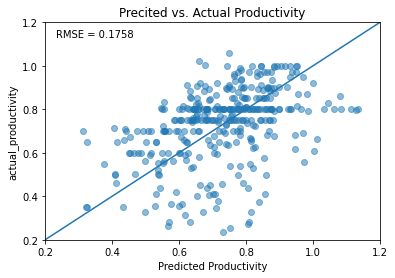

In [65]:
evaluate(predicted = y_predicted_NN, actual = y_test, RMSE = NN_error)

The Random Forest model had the lowest RMSE. What features were most important in that model?

In [66]:
feature_importances = pd.DataFrame(RFregr.feature_importances_, index =X_train.columns, columns=['importance']).sort_values('importance', ascending=False)
feature_importances

,importance
targeted_productivity,0.208438
incentive,0.130792
smv,0.126303
date,0.123302
no_of_workers,0.099760
over_time,0.074596
day_ordinal,0.052786
quarter_ordinal,0.037325
wip,0.019854
team_9,0.013412


Text(0.5, 0, 'Feature Importance')

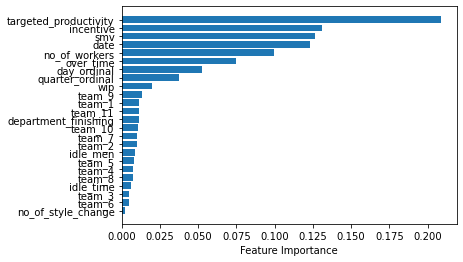

In [67]:
sorted_idx = RFregr.feature_importances_.argsort()
plt.barh(X_train.columns[sorted_idx], RFregr.feature_importances_[sorted_idx])
plt.xlabel('Feature Importance')

How do the more important features correlate with actual_productivity?

<AxesSubplot:xlabel='targeted_productivity', ylabel='actual_productivity'>

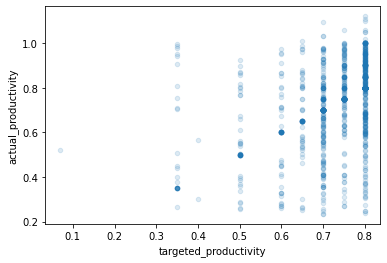

In [68]:
garment_prod.plot.scatter(x='targeted_productivity', y='actual_productivity', alpha = 0.15)

<AxesSubplot:xlabel='incentive', ylabel='actual_productivity'>

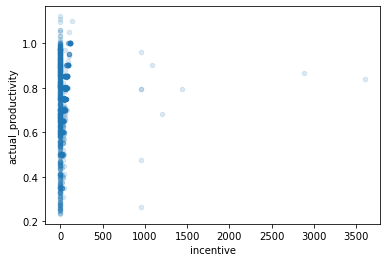

In [69]:
garment_prod.plot.scatter(x='incentive', y='actual_productivity', alpha = 0.15)

There were a few outliers where incentive was very large. Let's take a look at these.

In [70]:
hi_incentive = garment_prod.loc[garment_prod['incentive'] > 500]
hi_incentive

,date,quarter,department,day,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity
1128,2015-03-09,Quarter2,finishing,Monday,11,0.80,2.90,0.0,0,960,0.0,0,0,8.0,0.960625
1129,2015-03-09,Quarter2,finishing,Monday,12,0.80,4.60,0.0,0,1080,0.0,0,0,9.0,0.902963
1130,2015-03-09,Quarter2,finishing,Monday,5,0.60,3.94,0.0,0,2880,0.0,0,0,12.0,0.864343
1133,2015-03-09,Quarter2,finishing,Monday,9,0.75,2.90,0.0,0,3600,0.0,0,0,15.0,0.841000
1137,2015-03-09,Quarter2,finishing,Monday,3,0.80,4.60,0.0,0,1440,0.0,0,0,12.0,0.795417
1138,2015-03-09,Quarter2,finishing,Monday,4,0.75,3.94,0.0,0,960,0.0,0,0,8.0,0.795388
1139,2015-03-09,Quarter2,finishing,Monday,1,0.75,3.94,0.0,0,960,0.0,0,0,8.0,0.794567
1143,2015-03-09,Quarter2,finishing,Monday,2,0.70,3.90,0.0,0,1200,0.0,0,0,10.0,0.682500
1148,2015-03-09,Quarter2,finishing,Monday,10,0.70,2.90,0.0,0,960,0.0,0,0,8.0,0.477292
1149,2015-03-09,Quarter2,finishing,Monday,8,0.65,3.90,0.0,0,960,0.0,0,0,8.0,0.264062


These instances where exceptionally large incentives were offered all occurred on the same day, in the finishing department, on relatively short tasks (smv from 2.9 to 4.6). I exclude them as outliers to take a look at how incentive typically related to productivity.

(-5.0, 140.0)

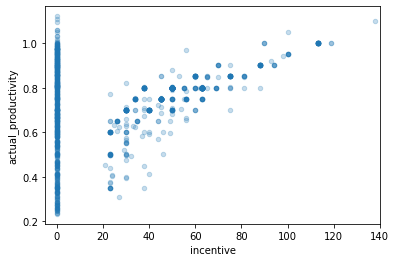

In [71]:
garment_prod.plot.scatter(x='incentive', y='actual_productivity', alpha = 0.25)
plt.xlim(-5, 140)

Often incentive was not offered, but when it was, it appeared to correlate positively with productivity.

<AxesSubplot:xlabel='smv', ylabel='actual_productivity'>

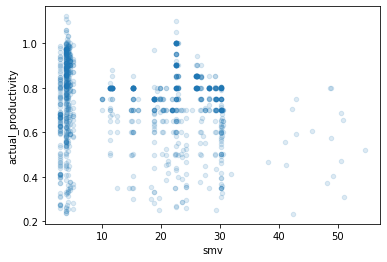

In [72]:
garment_prod.plot.scatter(x='smv', y='actual_productivity', alpha = 0.15)

The 'smv' feature appears to occur in three clusters, with the highest cluster possibly being associated with lower productivity. I will explore this idea a little later in this notebook.

<AxesSubplot:xlabel='date', ylabel='actual_productivity'>

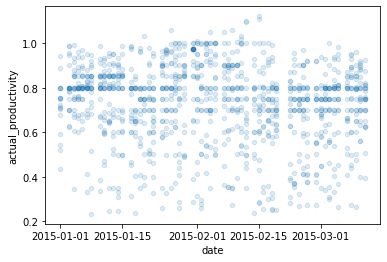

In [73]:
garment_prod.plot.scatter(x='date', y='actual_productivity', alpha = 0.15)

<AxesSubplot:xlabel='no_of_workers', ylabel='actual_productivity'>

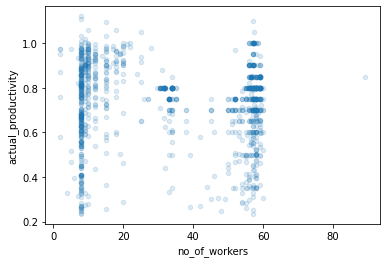

In [74]:
garment_prod.plot.scatter(x='no_of_workers', y='actual_productivity', alpha = 0.15)

<AxesSubplot:xlabel='over_time', ylabel='actual_productivity'>

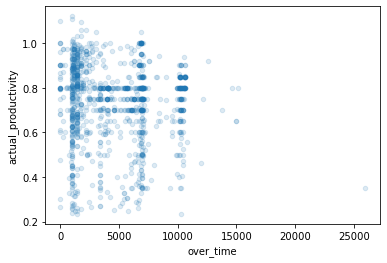

In [75]:
garment_prod.plot.scatter(x='over_time', y='actual_productivity', alpha = 0.15)
# plt.xlim(-100, 2000)

<AxesSubplot:xlabel='day', ylabel='actual_productivity'>

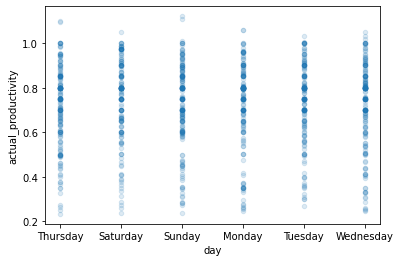

In [76]:
garment_prod.plot.scatter(x='day', y='actual_productivity', alpha = 0.15)

When incentive is offered, does it increase the ability to predict productivty? Select rows where an incentive was offered (exluding outliers with exceptionally high incentive -- see above), and preprocess for Random Forest. Also select rows with no incentive to predict effect of offering an incentive on productivity.

In [77]:
garment_prod_inc = garment_prod.loc[garment_prod['incentive'] > 0]
garment_prod_inc = garment_prod_inc.loc[garment_prod['incentive'] < 500]
garment_prod_noinc = garment_prod.loc[garment_prod['incentive'] == 0]
garment_prod_noinc.head(50)

,date,quarter,department,day,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity
1,2015-01-01,Quarter1,finishing,Thursday,1,0.75,3.94,0.0,960,0,0.0,0,0,8.0,0.886500
6,2015-01-01,Quarter1,finishing,Thursday,2,0.75,3.94,0.0,960,0,0.0,0,0,8.0,0.755167
13,2015-01-01,Quarter1,finishing,Thursday,10,0.65,3.94,0.0,960,0,0.0,0,0,8.0,0.705917
14,2015-01-01,Quarter1,finishing,Thursday,8,0.75,2.90,0.0,960,0,0.0,0,0,8.0,0.676667
15,2015-01-01,Quarter1,finishing,Thursday,4,0.75,3.94,0.0,2160,0,0.0,0,0,18.0,0.593056
16,2015-01-01,Quarter1,finishing,Thursday,7,0.80,2.90,0.0,960,0,0.0,0,0,8.0,0.540729
17,2015-01-01,Quarter1,sweing,Thursday,4,0.65,23.69,861.0,7200,0,0.0,0,0,60.0,0.521180
18,2015-01-01,Quarter1,finishing,Thursday,11,0.70,4.15,0.0,1440,0,0.0,0,0,12.0,0.436326
19,2015-01-03,Quarter1,finishing,Saturday,4,0.80,4.15,0.0,6600,0,0.0,0,0,20.0,0.988025
20,2015-01-03,Quarter1,finishing,Saturday,11,0.75,2.90,0.0,5640,0,0.0,0,0,17.0,0.987880


<AxesSubplot:xlabel='smv', ylabel='actual_productivity'>

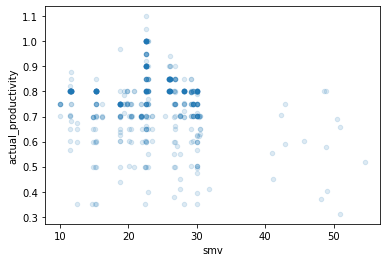

In [78]:
garment_prod_inc.plot.scatter(x='smv', y='actual_productivity', alpha = 0.15)

In [79]:
# calculate average daily productivity when no incentive offered.
daily_productivity_noinc = garment_prod_noinc.groupby('date').actual_productivity.mean()
avg_daily_productivity_noinc = daily_productivity_noinc.mean()

In [80]:
# Assign average incentive to rows where there was no incentive.
garment_prod_noinc['incentive'].replace(0, avg_daily_productivity_noinc, inplace = True)
garment_prod_noinc.head()

,date,quarter,department,day,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity
1,2015-01-01,Quarter1,finishing,Thursday,1,0.75,3.94,0.0,960,0.712347,0.0,0,0,8.0,0.886500
6,2015-01-01,Quarter1,finishing,Thursday,2,0.75,3.94,0.0,960,0.712347,0.0,0,0,8.0,0.755167
13,2015-01-01,Quarter1,finishing,Thursday,10,0.65,3.94,0.0,960,0.712347,0.0,0,0,8.0,0.705917
14,2015-01-01,Quarter1,finishing,Thursday,8,0.75,2.90,0.0,960,0.712347,0.0,0,0,8.0,0.676667
15,2015-01-01,Quarter1,finishing,Thursday,4,0.75,3.94,0.0,2160,0.712347,0.0,0,0,18.0,0.593056


In [81]:
garment_prod_inc.describe()

,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity
count,583.00000,583.000000,583.000000,583.000000,583.000000,583.000000,583.000000,583.000000,583.000000,583.000000,583.000000
mean,6.58319,0.735334,22.931852,1250.025729,6609.399657,52.723842,0.285592,0.171527,0.214408,52.215266,0.758365
std,3.59785,0.091963,7.065409,1984.219356,2953.371665,21.625862,6.219593,1.822373,0.511381,9.737291,0.123125
min,1.00000,0.350000,10.050000,7.000000,0.000000,21.000000,0.000000,0.000000,0.000000,26.000000,0.311207
25%,3.00000,0.700000,18.790000,827.000000,4455.000000,38.000000,0.000000,0.000000,0.000000,52.000000,0.700507
50%,6.00000,0.750000,22.520000,1065.000000,6840.000000,50.000000,0.000000,0.000000,0.000000,57.000000,0.800015
75%,10.00000,0.800000,27.480000,1263.000000,9540.000000,63.000000,0.000000,0.000000,0.000000,58.000000,0.800594
max,12.00000,0.800000,54.560000,23122.000000,25920.000000,138.000000,150.000000,30.000000,2.000000,89.000000,1.100484


Next, group predictor columns according to data type into three dataframes for preprocessing: nominal categorical, ordinal categorical, & numerical. 

In [82]:
# Select nominal categorical columns for encoding.
garment_nominal_inc = garment_prod_inc[['department', 'team']]
garment_nominal_noinc = garment_prod_noinc[['department', 'team']]
garment_nominal_inc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 583 entries, 0 to 1191
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   department  583 non-null    object
 1   team        583 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 13.7+ KB


In [83]:
# Select ordinal categorical columns for encoding.
garment_ordinal_inc = garment_prod_inc[['date', 'quarter', 'day']]
garment_ordinal_noinc = garment_prod_noinc[['date', 'quarter', 'day']]
garment_ordinal_inc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 583 entries, 0 to 1191
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   date     583 non-null    datetime64[ns]
 1   quarter  583 non-null    object        
 2   day      583 non-null    object        
dtypes: datetime64[ns](1), object(2)
memory usage: 18.2+ KB


In [84]:
# Select numerical columns.
garment_numerical_inc = garment_prod_inc.iloc[:, 5:]
garment_numerical_noinc = garment_prod_noinc.iloc[:, 5:]
garment_numerical_inc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 583 entries, 0 to 1191
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   targeted_productivity  583 non-null    float64
 1   smv                    583 non-null    float64
 2   wip                    583 non-null    float64
 3   over_time              583 non-null    int64  
 4   incentive              583 non-null    int64  
 5   idle_time              583 non-null    float64
 6   idle_men               583 non-null    int64  
 7   no_of_style_change     583 non-null    int64  
 8   no_of_workers          583 non-null    float64
 9   actual_productivity    583 non-null    float64
dtypes: float64(6), int64(4)
memory usage: 50.1 KB


Encode nominal features, 'department' and 'team', using One Hot. First, check number of categories in each of these columns.

In [85]:
garment_nominal_inc.iloc[:, 0].unique()

array(['sweing'], dtype=object)

In [86]:
garment_nominal_noinc.iloc[:, 0].unique()

array(['finishing ', 'sweing', 'finishing'], dtype=object)

In [87]:
garment_nominal_noinc.iloc[:, 0].replace({'sweing': 'sewing', 'finishing ': 'finishing'}, inplace=True)
garment_nominal_noinc.iloc[:, 0].unique()

array(['finishing', 'sewing'], dtype=object)

In garment_nominal_inc these rows only have 'sewing' for 'department' feature, so delete column.

In [88]:
garment_nominal_inc.drop(columns = ['department'], inplace = True)
garment_nominal_inc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 583 entries, 0 to 1191
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   team    583 non-null    int64
dtypes: int64(1)
memory usage: 9.1 KB


In [89]:
team_categories_inc = garment_nominal_inc['team'].unique()
team_categories_inc.sort(axis=0)
team_categories_inc

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12], dtype=int64)

Utilize get_dummies to encode nominal columns using OHE. Function drops orgininal columns.

In [90]:
garment_nom_encoded_inc = pd.get_dummies(garment_nominal_inc, columns = ['team'])
garment_nom_encoded_noinc = pd.get_dummies(garment_nominal_noinc, columns = ['department', 'team'])
garment_nom_encoded_inc.head()

,team_1,team_2,team_3,team_4,team_5,team_6,team_7,team_8,team_9,team_10,team_11,team_12
0,0,0,0,0,0,0,0,1,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,1,0
3,0,0,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,1,0,0,0,0,0,0
5,0,0,0,0,0,0,1,0,0,0,0,0


In [91]:
# Double check that all data were encoded.
garment_nom_encoded_inc.info()
garment_nom_encoded_noinc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 583 entries, 0 to 1191
Data columns (total 12 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   team_1   583 non-null    uint8
 1   team_2   583 non-null    uint8
 2   team_3   583 non-null    uint8
 3   team_4   583 non-null    uint8
 4   team_5   583 non-null    uint8
 5   team_6   583 non-null    uint8
 6   team_7   583 non-null    uint8
 7   team_8   583 non-null    uint8
 8   team_9   583 non-null    uint8
 9   team_10  583 non-null    uint8
 10  team_11  583 non-null    uint8
 11  team_12  583 non-null    uint8
dtypes: uint8(12)
memory usage: 11.4 KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 604 entries, 1 to 1196
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype
---  ------                --------------  -----
 0   department_finishing  604 non-null    uint8
 1   department_sewing     604 non-null    uint8
 2   team_1                604 non-null    uint8

Encode 'quarter' and 'day' using ordinal encoder. Use sequence of integers as values in dictionaries to map data in the "quarter" and "day" columns to integers in new columns.

In [92]:
# turn off chained assignments warning (false positive) because mapping to new columns is working.
pd.set_option('chained_assignment', None)
Quarter_dict_inc = {'Quarter1': 1, 'Quarter2': 2, 'Quarter3': 3, 'Quarter4': 4, 'Quarter5': 5}
garment_ordinal_inc['quarter_ordinal'] = garment_ordinal_inc.loc[:, 'quarter'].map(Quarter_dict_inc)
garment_ordinal_noinc['quarter_ordinal'] = garment_ordinal_noinc.loc[:, 'quarter'].map(Quarter_dict_inc)

Day_dict_inc = {'Monday': 1, 'Tuesday': 2, 'Wednesday': 3, 'Thursday': 4, 'Friday': 5, 'Saturday': 6, 'Sunday': 7}
garment_ordinal_inc['day_ordinal'] = garment_ordinal_inc.loc[:, 'day'].map(Day_dict_inc)
garment_ordinal_noinc['day_ordinal'] = garment_ordinal_noinc.loc[:, 'day'].map(Day_dict_inc)
garment_ordinal_noinc.head()

,date,quarter,day,quarter_ordinal,day_ordinal
1,2015-01-01,Quarter1,Thursday,1,4
6,2015-01-01,Quarter1,Thursday,1,4
13,2015-01-01,Quarter1,Thursday,1,4
14,2015-01-01,Quarter1,Thursday,1,4
15,2015-01-01,Quarter1,Thursday,1,4


In [93]:
garment_ordinal_inc.drop(labels=['quarter', 'day'], axis=1, inplace=True)
garment_ordinal_noinc.drop(labels=['quarter', 'day'], axis=1, inplace=True)
garment_ordinal_noinc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 604 entries, 1 to 1196
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   date             604 non-null    datetime64[ns]
 1   quarter_ordinal  604 non-null    int64         
 2   day_ordinal      604 non-null    int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 18.9 KB


To use datetime in regression, perform ordinal encoding by mapping with python's datetime.toordinal method.

In [94]:
from datetime import datetime 
garment_ordinal_inc['date'] = garment_ordinal_inc['date'].map(datetime.toordinal)
garment_ordinal_noinc['date'] = garment_ordinal_noinc['date'].map(datetime.toordinal)
garment_ordinal_noinc['date'].describe()

count       604.00000
mean     735634.27649
std          20.10127
min      735599.00000
25%      735616.00000
50%      735635.00000
75%      735652.00000
max      735668.00000
Name: date, dtype: float64

Concatenate encoded nominal and ordinal columns.

In [95]:
garment_categorical_inc = pd.concat([garment_nom_encoded_inc, garment_ordinal_inc], axis=1)
garment_categorical_noinc = pd.concat([garment_nom_encoded_noinc, garment_ordinal_noinc], axis=1)
garment_categorical_noinc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 604 entries, 1 to 1196
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype
---  ------                --------------  -----
 0   department_finishing  604 non-null    uint8
 1   department_sewing     604 non-null    uint8
 2   team_1                604 non-null    uint8
 3   team_2                604 non-null    uint8
 4   team_3                604 non-null    uint8
 5   team_4                604 non-null    uint8
 6   team_5                604 non-null    uint8
 7   team_6                604 non-null    uint8
 8   team_7                604 non-null    uint8
 9   team_8                604 non-null    uint8
 10  team_9                604 non-null    uint8
 11  team_10               604 non-null    uint8
 12  team_11               604 non-null    uint8
 13  team_12               604 non-null    uint8
 14  date                  604 non-null    int64
 15  quarter_ordinal       604 non-null    int64
 16  day_ord

Drop last department & team columns to reduce impacts on regression models by the multicollinearity introduced by OHE encoding. The information in the deleted columns is still available to the model, though, because if the value of the deleted column was 1, the row will now have 0's for all remaining columns encoding that feature.

In [96]:
garment_categorical_inc.drop(labels = ['team_12'], axis = 1, inplace = True)
garment_categorical_noinc.drop(labels = ['team_12'], axis = 1, inplace = True)
garment_categorical_noinc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 604 entries, 1 to 1196
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype
---  ------                --------------  -----
 0   department_finishing  604 non-null    uint8
 1   department_sewing     604 non-null    uint8
 2   team_1                604 non-null    uint8
 3   team_2                604 non-null    uint8
 4   team_3                604 non-null    uint8
 5   team_4                604 non-null    uint8
 6   team_5                604 non-null    uint8
 7   team_6                604 non-null    uint8
 8   team_7                604 non-null    uint8
 9   team_8                604 non-null    uint8
 10  team_9                604 non-null    uint8
 11  team_10               604 non-null    uint8
 12  team_11               604 non-null    uint8
 13  date                  604 non-null    int64
 14  quarter_ordinal       604 non-null    int64
 15  day_ordinal           604 non-null    int64
dtypes: int6

Select predictor and target columns and split into train and test subsets, then scale (fit & transform) X_train and transform X_test using fit parameters from X_train.

In [97]:
# Concatenate categorical & numerical columns & save complete data set.
garment_prepped_inc = pd.concat([garment_categorical_inc, garment_numerical_inc], axis=1)
garment_prepped_noinc = pd.concat([garment_categorical_noinc, garment_numerical_noinc], axis=1)
# Drop target 'actual_productivity' from predictors.
X_inc = garment_prepped_inc.drop(columns = 'actual_productivity')
X_noinc = garment_prepped_noinc.drop(columns = 'actual_productivity')
X_noinc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 604 entries, 1 to 1196
Data columns (total 25 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   department_finishing   604 non-null    uint8  
 1   department_sewing      604 non-null    uint8  
 2   team_1                 604 non-null    uint8  
 3   team_2                 604 non-null    uint8  
 4   team_3                 604 non-null    uint8  
 5   team_4                 604 non-null    uint8  
 6   team_5                 604 non-null    uint8  
 7   team_6                 604 non-null    uint8  
 8   team_7                 604 non-null    uint8  
 9   team_8                 604 non-null    uint8  
 10  team_9                 604 non-null    uint8  
 11  team_10                604 non-null    uint8  
 12  team_11                604 non-null    uint8  
 13  date                   604 non-null    int64  
 14  quarter_ordinal        604 non-null    int64  
 15  day_o

In [98]:
y_inc = garment_prod_inc['actual_productivity']

In [99]:
# Split into train & test subsets before scaling.
X_train_inc,X_test_inc,y_train_inc,y_test_inc = train_test_split(X_inc, y_inc, test_size=0.3, random_state=0) 
X_train_inc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 408 entries, 501 to 1152
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   team_1                 408 non-null    uint8  
 1   team_2                 408 non-null    uint8  
 2   team_3                 408 non-null    uint8  
 3   team_4                 408 non-null    uint8  
 4   team_5                 408 non-null    uint8  
 5   team_6                 408 non-null    uint8  
 6   team_7                 408 non-null    uint8  
 7   team_8                 408 non-null    uint8  
 8   team_9                 408 non-null    uint8  
 9   team_10                408 non-null    uint8  
 10  team_11                408 non-null    uint8  
 11  date                   408 non-null    int64  
 12  quarter_ordinal        408 non-null    int64  
 13  day_ordinal            408 non-null    int64  
 14  targeted_productivity  408 non-null    float64
 15  smv

In [100]:
# Select predictors for scaling, including numerical and encoded ordinal columns.
X_train_scalable_inc = X_train_inc.drop(X_inc.iloc[:, 0:11], axis = 1)
X_test_scalable_inc = X_test_inc.drop(X_inc.iloc[:, 0:11], axis = 1)
X_test_scalable_inc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 175 entries, 454 to 777
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   date                   175 non-null    int64  
 1   quarter_ordinal        175 non-null    int64  
 2   day_ordinal            175 non-null    int64  
 3   targeted_productivity  175 non-null    float64
 4   smv                    175 non-null    float64
 5   wip                    175 non-null    float64
 6   over_time              175 non-null    int64  
 7   incentive              175 non-null    int64  
 8   idle_time              175 non-null    float64
 9   idle_men               175 non-null    int64  
 10  no_of_style_change     175 non-null    int64  
 11  no_of_workers          175 non-null    float64
dtypes: float64(5), int64(7)
memory usage: 17.8 KB


In [101]:
# Scale ordinal & numerical columns in X_train,convert ndarray output to dataframe as float dtype, & name columns.
scaler_inc = StandardScaler()
X_train_scaling_inc = scaler_inc.fit_transform(X_train_scalable_inc)
X_train_scaled_inc = pd.DataFrame(X_train_scaling_inc)
X_train_scaled_inc = X_train_scaled_inc.astype('float')
X_train_scaled_inc.columns = ['date', 'quarter_ordinal','day_ordinal', 'targeted_productivity', 'smv', 'wip', 'over_time', 'incentive', 'idle_time', 'idle_men', 'no_of_style_change', 'no_of_workers']

X_train_scaled_inc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 408 entries, 0 to 407
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   date                   408 non-null    float64
 1   quarter_ordinal        408 non-null    float64
 2   day_ordinal            408 non-null    float64
 3   targeted_productivity  408 non-null    float64
 4   smv                    408 non-null    float64
 5   wip                    408 non-null    float64
 6   over_time              408 non-null    float64
 7   incentive              408 non-null    float64
 8   idle_time              408 non-null    float64
 9   idle_men               408 non-null    float64
 10  no_of_style_change     408 non-null    float64
 11  no_of_workers          408 non-null    float64
dtypes: float64(12)
memory usage: 38.4 KB


In [102]:
# Use fit paramaters from X_train to transform X_test, then convert back to df.
X_test_scaling_inc = scaler.transform(X_test_scalable_inc)
X_test_scaled_inc = pd.DataFrame(X_test_scaling_inc)
X_test_scaled_inc = X_test_scaled_inc.astype('float')
X_test_scaled_inc.columns = ['date', 'quarter_ordinal','day_ordinal', 'targeted_productivity', 'smv', 'wip', 'over_time', 'incentive', 'idle_time', 'idle_men', 'no_of_style_change', 'no_of_workers']
X_test_scaled_inc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175 entries, 0 to 174
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   date                   175 non-null    float64
 1   quarter_ordinal        175 non-null    float64
 2   day_ordinal            175 non-null    float64
 3   targeted_productivity  175 non-null    float64
 4   smv                    175 non-null    float64
 5   wip                    175 non-null    float64
 6   over_time              175 non-null    float64
 7   incentive              175 non-null    float64
 8   idle_time              175 non-null    float64
 9   idle_men               175 non-null    float64
 10  no_of_style_change     175 non-null    float64
 11  no_of_workers          175 non-null    float64
dtypes: float64(12)
memory usage: 16.5 KB


Select binary columns (encoded nominal features) in X_train and X_test, then concatenate with scaled columns to make complete train and test dataframes. 

In [103]:
X_train_binary_inc = X_train_inc.iloc[:, 0:11]
X_test_binary_inc = X_test_inc.iloc[:, 0:11]
X_train_binary_inc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 408 entries, 501 to 1152
Data columns (total 11 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   team_1   408 non-null    uint8
 1   team_2   408 non-null    uint8
 2   team_3   408 non-null    uint8
 3   team_4   408 non-null    uint8
 4   team_5   408 non-null    uint8
 5   team_6   408 non-null    uint8
 6   team_7   408 non-null    uint8
 7   team_8   408 non-null    uint8
 8   team_9   408 non-null    uint8
 9   team_10  408 non-null    uint8
 10  team_11  408 non-null    uint8
dtypes: uint8(11)
memory usage: 7.6 KB


In [104]:
# Reset index on binary dataframes to match indexing on scaled dataframes, whose indexing was reset during scaling process.
X_train_binary_inc.reset_index(drop = True, inplace = True)
X_test_binary_inc.reset_index(drop = True, inplace = True)

In [105]:
X_train_inc = pd.concat([X_train_binary_inc, X_train_scaled_inc], axis=1)
X_train_inc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 408 entries, 0 to 407
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   team_1                 408 non-null    uint8  
 1   team_2                 408 non-null    uint8  
 2   team_3                 408 non-null    uint8  
 3   team_4                 408 non-null    uint8  
 4   team_5                 408 non-null    uint8  
 5   team_6                 408 non-null    uint8  
 6   team_7                 408 non-null    uint8  
 7   team_8                 408 non-null    uint8  
 8   team_9                 408 non-null    uint8  
 9   team_10                408 non-null    uint8  
 10  team_11                408 non-null    uint8  
 11  date                   408 non-null    float64
 12  quarter_ordinal        408 non-null    float64
 13  day_ordinal            408 non-null    float64
 14  targeted_productivity  408 non-null    float64
 15  smv   

In [106]:
X_test_inc = pd.concat([X_test_binary_inc, X_test_scaled_inc], axis=1)
X_test_inc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175 entries, 0 to 174
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   team_1                 175 non-null    uint8  
 1   team_2                 175 non-null    uint8  
 2   team_3                 175 non-null    uint8  
 3   team_4                 175 non-null    uint8  
 4   team_5                 175 non-null    uint8  
 5   team_6                 175 non-null    uint8  
 6   team_7                 175 non-null    uint8  
 7   team_8                 175 non-null    uint8  
 8   team_9                 175 non-null    uint8  
 9   team_10                175 non-null    uint8  
 10  team_11                175 non-null    uint8  
 11  date                   175 non-null    float64
 12  quarter_ordinal        175 non-null    float64
 13  day_ordinal            175 non-null    float64
 14  targeted_productivity  175 non-null    float64
 15  smv   

In [107]:
RFregr_inc = RandomForestRegressor(random_state=0)
RFregr_inc.fit(X_train_inc, y_train_inc)

RandomForestRegressor(random_state=0)

In [108]:
# predict y to evaluate model 
y_predicted_RFregr_inc = RFregr_inc.predict(X_test_inc)
# calculate RMSE
RFregr_inc_error = 'RMSE = {:.4f}'.format(mean_squared_error(y_predicted_RFregr_inc, y_test_inc, squared = False))

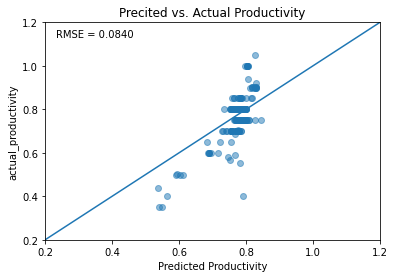

In [109]:
evaluate(predicted = y_predicted_RFregr_inc, actual = y_test_inc, RMSE = RFregr_inc_error)

The result above shows that offering incentive increases productivity and increases the Random Forest model's predictive accuracy. By selecting the most important features, can we simplify the model without compromising accuracy?

In [110]:
feature_importances_inc = pd.DataFrame(RFregr_inc.feature_importances_, index =X_train_inc.columns, columns=['importance']).sort_values('importance', ascending=False)
feature_importances_inc

,importance
incentive,0.594905
targeted_productivity,0.284943
smv,0.040845
wip,0.017736
date,0.012450
over_time,0.011400
no_of_workers,0.006455
quarter_ordinal,0.005103
day_ordinal,0.005013
team_11,0.004379


Text(0.5, 0, 'Feature Importance')

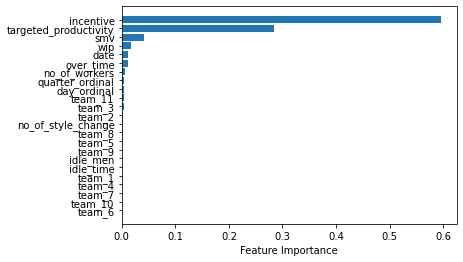

In [111]:
sorted_idx_inc = RFregr_inc.feature_importances_.argsort()
plt.barh(X_train_inc.columns[sorted_idx_inc], RFregr_inc.feature_importances_[sorted_idx_inc])
plt.xlabel('Feature Importance')

In [112]:
X_train_inc_selected = X_train_inc.loc[:, ['incentive', 'targeted_productivity', 'smv', 'wip', 'over_time', 'no_of_workers', 'quarter_ordinal', 'day_ordinal']]
X_test_inc_selected = X_test_inc.loc[:, ['incentive', 'targeted_productivity', 'smv', 'wip', 'over_time', 'no_of_workers', 'quarter_ordinal', 'day_ordinal']]
RFregr_inc_selected = RandomForestRegressor(random_state=0)
RFregr_inc_selected.fit(X_train_inc_selected, y_train_inc)

RandomForestRegressor(random_state=0)

In [113]:
# predict y to evaluate model 
y_predicted_RFregr_inc_selected = RFregr_inc_selected.predict(X_test_inc_selected)
# calculate RMSE
RFregr_inc_selected_error = 'RMSE = {:.4f}'.format(mean_squared_error(y_predicted_RFregr_inc_selected, y_test_inc, squared = False))

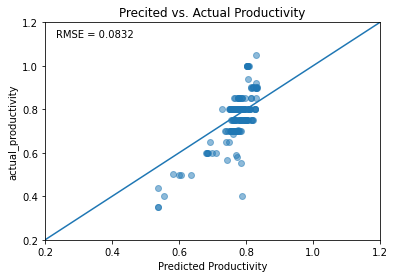

In [114]:
evaluate(predicted = y_predicted_RFregr_inc_selected, actual = y_test_inc, RMSE = RFregr_inc_selected_error)

I was able to drop almost 2/3 of the features from the model without an increase in error. These results indicate that incentives predictably increase productivity, and expanding the use of incentives may be a strategy worth pursuing. 

If an average incentive were offered, how much would productivity increase according to this model?

In [115]:
# Predict productivity after setting incentive to equal the average incentive for rows where originally none was offered.
X_noinc_selected = X_noinc.loc[:, ['incentive', 'targeted_productivity', 'smv', 'wip', 'over_time', 'no_of_workers', 'quarter_ordinal', 'day_ordinal']]
y_predicted_RFregr_noinc = pd.DataFrame(RFregr_inc_selected.predict(X_noinc_selected), columns = ['predicted_productivity'])
# To be able to compute average daily productivity, concatenate with X_noinc
incentivised = pd.concat([X_noinc, y_predicted_RFregr_noinc], axis=1)
incentivised.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 923 entries, 0 to 1196
Data columns (total 26 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   department_finishing    604 non-null    float64
 1   department_sewing       604 non-null    float64
 2   team_1                  604 non-null    float64
 3   team_2                  604 non-null    float64
 4   team_3                  604 non-null    float64
 5   team_4                  604 non-null    float64
 6   team_5                  604 non-null    float64
 7   team_6                  604 non-null    float64
 8   team_7                  604 non-null    float64
 9   team_8                  604 non-null    float64
 10  team_9                  604 non-null    float64
 11  team_10                 604 non-null    float64
 12  team_11                 604 non-null    float64
 13  date                    604 non-null    float64
 14  quarter_ordinal         604 non-null    f

In [116]:
print('Avg. daily productivity without incentive = {:.4f}'.format(avg_daily_productivity_noinc))

Avg. daily productivity without incentive = 0.7123


In [117]:
# calculate average daily productivity for same instances with average incentive added.
daily_productivity_incentivised = incentivised.groupby('date').predicted_productivity.mean()
avg_daily_productivity_incentivised = daily_productivity_incentivised.mean()
print('Avg. daily productivity with incentive = {:.4f}'.format(avg_daily_productivity_incentivised))

Avg. daily productivity with incentive = 0.8074


In [118]:
productivity_increase = (avg_daily_productivity_incentivised - avg_daily_productivity_noinc)/avg_daily_productivity_noinc * 100
print('Productivity increase with incentive = {:.2f}%'.format(productivity_increase))

Productivity increase with incentive = 13.34%


According to this model, offering an average incentive on tasks with no incentive increases their average daily productivity by 13.34%.

Next, I predict the degree to which productivity could be increased by breaking up longer tasks into shorter ones. I will select the cluster of rows that fell into the highest cluster of smv values (see "smv" plot above), then decrease their smv by 1/2 and run through the model. Because prediction accuracy is much higher when incentives are included, I will restrict this simulation to the model trained on the garment_prod_inc subset (which excludes rows where incentive = 0).

In [119]:
# Select X_test rows where smv >= 35 for analysis later (to predict increase in productivity by reducing smv).
X_hi_smv = X_inc.loc[X_inc['smv'] >= 35]
X_hi_smv['smv']

59     45.67
209    50.48
230    42.27
257    51.02
287    48.68
297    41.19
303    48.84
316    49.10
332    48.84
367    54.56
388    40.99
407    42.97
434    42.97
476    48.18
537    50.89
Name: smv, dtype: float64

In [120]:
# Select corresponding y values (productivity) for these rows.
y_hi_smv = garment_prod_inc.loc[garment_prod_inc['smv'] > 35, 'actual_productivity']
y_hi_smv

59     0.603432
209    0.688558
230    0.705577
257    0.311207
287    0.800117
297    0.452013
303    0.800129
316    0.403242
332    0.576460
367    0.520238
388    0.555500
407    0.750041
434    0.591142
476    0.370467
537    0.656764
Name: actual_productivity, dtype: float64

In [121]:
# Lower smv for these rows by 50%
X_lowered_smv = X_hi_smv
X_lowered_smv['smv'] = X_lowered_smv['smv'] * 0.5
X_lowered_smv['smv']

59     22.835
209    25.240
230    21.135
257    25.510
287    24.340
297    20.595
303    24.420
316    24.550
332    24.420
367    27.280
388    20.495
407    21.485
434    21.485
476    24.090
537    25.445
Name: smv, dtype: float64

In [122]:
X_lowered_smv.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15 entries, 59 to 537
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   team_1                 15 non-null     uint8  
 1   team_2                 15 non-null     uint8  
 2   team_3                 15 non-null     uint8  
 3   team_4                 15 non-null     uint8  
 4   team_5                 15 non-null     uint8  
 5   team_6                 15 non-null     uint8  
 6   team_7                 15 non-null     uint8  
 7   team_8                 15 non-null     uint8  
 8   team_9                 15 non-null     uint8  
 9   team_10                15 non-null     uint8  
 10  team_11                15 non-null     uint8  
 11  date                   15 non-null     int64  
 12  quarter_ordinal        15 non-null     int64  
 13  day_ordinal            15 non-null     int64  
 14  targeted_productivity  15 non-null     float64
 15  smv   

In [123]:
# Select predictors for scaling, including numerical and encoded ordinal columns.
X_lowered_smv_scalable = X_lowered_smv.drop(X_lowered_smv.iloc[:, 0:11], axis = 1)
X_lowered_smv_scalable.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15 entries, 59 to 537
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   date                   15 non-null     int64  
 1   quarter_ordinal        15 non-null     int64  
 2   day_ordinal            15 non-null     int64  
 3   targeted_productivity  15 non-null     float64
 4   smv                    15 non-null     float64
 5   wip                    15 non-null     float64
 6   over_time              15 non-null     int64  
 7   incentive              15 non-null     int64  
 8   idle_time              15 non-null     float64
 9   idle_men               15 non-null     int64  
 10  no_of_style_change     15 non-null     int64  
 11  no_of_workers          15 non-null     float64
dtypes: float64(5), int64(7)
memory usage: 1.5 KB


In [124]:
# Use fit paramaters from X_train to transform X_lowered_smv, then convert back to df.
X_lowered_smv_scaling = scaler.transform(X_lowered_smv_scalable)
X_lowered_smv_scaled = pd.DataFrame(X_lowered_smv_scaling)
X_lowered_smv_scaled = X_lowered_smv_scaled.astype('float')
X_lowered_smv_scaled.columns = ['date', 'quarter_ordinal','day_ordinal', 'targeted_productivity', 'smv', 'wip', 'over_time', 'incentive', 'idle_time', 'idle_men', 'no_of_style_change', 'no_of_workers']
X_lowered_smv_scaled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15 entries, 0 to 14
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   date                   15 non-null     float64
 1   quarter_ordinal        15 non-null     float64
 2   day_ordinal            15 non-null     float64
 3   targeted_productivity  15 non-null     float64
 4   smv                    15 non-null     float64
 5   wip                    15 non-null     float64
 6   over_time              15 non-null     float64
 7   incentive              15 non-null     float64
 8   idle_time              15 non-null     float64
 9   idle_men               15 non-null     float64
 10  no_of_style_change     15 non-null     float64
 11  no_of_workers          15 non-null     float64
dtypes: float64(12)
memory usage: 1.5 KB


In [125]:
# # Select binary columns (encoded nominal features). 
X_lowered_smv_binary = X_lowered_smv.iloc[:, 0:12]
# Reset index on binary dataframe to match indexing on scaled dataframe, whose indexing was reset during scaling.
X_lowered_smv_binary.reset_index(drop = True, inplace = True)
# Concatenate with scaled columns.
X_lowered_smv = pd.concat([X_lowered_smv_binary, X_lowered_smv_scaled], axis=1)
X_lowered_smv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15 entries, 0 to 14
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   team_1                 15 non-null     uint8  
 1   team_2                 15 non-null     uint8  
 2   team_3                 15 non-null     uint8  
 3   team_4                 15 non-null     uint8  
 4   team_5                 15 non-null     uint8  
 5   team_6                 15 non-null     uint8  
 6   team_7                 15 non-null     uint8  
 7   team_8                 15 non-null     uint8  
 8   team_9                 15 non-null     uint8  
 9   team_10                15 non-null     uint8  
 10  team_11                15 non-null     uint8  
 11  date                   15 non-null     int64  
 12  date                   15 non-null     float64
 13  quarter_ordinal        15 non-null     float64
 14  day_ordinal            15 non-null     float64
 15  targeted

In [126]:
#Use model to predict productivity after lowering smv.
productivity_lowered_smv = RFregr.predict(X_lowered_smv)
productivity_lowered_smv

array([0.64132215, 0.79371474, 0.78326839, 0.71231216, 0.81275786,
       0.60301644, 0.8045266 , 0.74182159, 0.73396054, 0.74494035,
       0.73863131, 0.78421901, 0.75158241, 0.4048225 , 0.72391172])

In [127]:
# Calculate increase in productivity due to lowering smv.
hi_smv_productivity = y_hi_smv.mean()
lowered_smv_productivity = productivity_lowered_smv.mean()
percent_increase_in_productivity = ((lowered_smv_productivity - hi_smv_productivity)/lowered_smv_productivity)*100
percent_increase_in_productivity

18.46828397817402

In [128]:
# How much of the work consists of longer tasks, where smv > 35? 
# Calculate smv * no_of_workers as measure of the amount of work per task
sum_hi_smv = np.sum(X_hi_smv['smv'] * X_hi_smv['no_of_workers'])
# garment_prod['worker_smv'] = garment_prod['smv'] * garment_prod['no_of_workers']
sum_all_smv = np.sum(garment_prod['smv'] * garment_prod['no_of_workers'])
percent_work_hi_smv = (sum_hi_smv/sum_all_smv)*100
percent_work_hi_smv

2.2747813671918085

In summary, this analysis indicates that breaking longer tasks into shorter subtasks could improve productivity. For the longest 2.3% of the total work in the dataset, dividing the tasks in half could increase productivity for that work by 18.5%. 